In [62]:
# Ivan Chow
# I pledge my honor that I have abided by the Stevens Honor System.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# fetch dataset
bike_sharing = fetch_ucirepo(id=275)

# data (as pandas dataframes)
X = bike_sharing.data.features
Y = bike_sharing.data.targets

# delete first col
X = X.drop(X.columns[0], axis=1)

# metadata
# print(bike_sharing.metadata)

# variable information
# print(bike_sharing.variables)

# X.head()
# y.head()

#Splitting Training Data into Training and Test Sets

In [63]:
# 80% training 20% testing

def manual_train_test_split(X, Y, test_size=0.2):
    # Get the number of data points
    num_data_points = X.shape[0]

    # Generate shuffled indices
    shuffled_indices = np.random.permutation(num_data_points)

    # Calculate the number of test samples
    test_set_size = int(num_data_points * test_size)

    # Split indices into test and train
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]

    # Use the indices to split the data
    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]
    Y_train = Y.iloc[train_indices]
    Y_test = Y.iloc[test_indices]

    return X_train, X_test, Y_train, Y_test

# Perform the manual train-test split
X_train, X_test, Y_train, Y_test = manual_train_test_split(X, Y, test_size=0.2)


#Adding Intercept Terms

In [64]:
X_train_intercept = np.column_stack([np.ones(X_train.shape[0]), X_train])
X_test_intercept = np.column_stack([np.ones(X_test.shape[0]), X_test])

#Standardize Data

In [65]:
def standardize(X_train, X_test):
  mean = np.mean(X_train, axis = 0)
  std = np.std(X_train, axis = 0)

  # prevent div by 0
  std[std == 0] = 1

  X_train_scaled = (X_train - mean) / std
  X_test_scaled = (X_test - mean) / std
  return X_train_scaled, X_test_scaled

In [66]:
X_train_scaled, X_test_scaled = standardize(X_train.values, X_test.values)

In [67]:
X_train_intercept_scaled = np.column_stack([np.ones(X_train_scaled.shape[0]), X_train_scaled])
X_test_intercept_scaled = np.column_stack([np.ones(X_test_scaled.shape[0]), X_test_scaled])

#Compute Mini-Batch Gradient Descent

In [68]:
def mgd(X, Y, learning_rate = 0.01, n_iterations = 1000, batch_size = 50):
  m, n = X.shape
  theta = np.random.randn(n, 1)
  mse_history = []

  for iteration in range(n_iterations):
    for i in range(0, m, batch_size):
      random_index = np.random.randint(m)
      x_batch = X[random_index:random_index + batch_size]
      y_batch = Y[random_index:random_index + batch_size]
      gradients = 2 * x_batch.T.dot(x_batch.dot(theta) - y_batch)
      theta = theta - learning_rate * gradients

    # Store MSE for every iteration
    mse = np.mean((X.dot(theta) - Y) ** 2)
    mse_history.append(mse)

    if iteration % 100 == 0 and iteration != 0:
      print(f"Iteration {iteration}: MSE = {mse}")

  return theta, mse_history

In [69]:
theta_mgd, mse_history = mgd(X_train_intercept_scaled, Y_train, learning_rate = 0.00001, n_iterations = 100, batch_size = 50)

#Evaluating Model

In [70]:
X_pred_sgd = np.dot(X_test_intercept_scaled, theta_mgd)

In [71]:
mse_mgd = np.mean((X_pred_sgd - X_test.values) ** 2)
print(f"MGD MSE: {mse_mgd}")

MGD MSE: 47751.74517576337


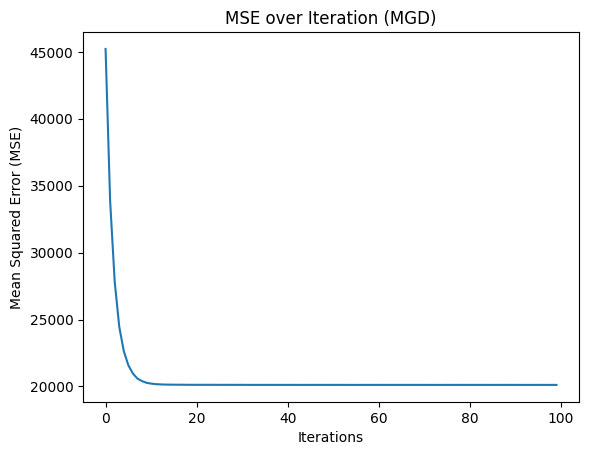

In [72]:
plt.plot(mse_history)
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE over Iteration (MGD)')
plt.show()

#MSE On Test Data

In [75]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Setting up K-Fold Cross Validation
k = 10
kf = KFold(n_splits = 10, random_state = 1, shuffle = True)

# Initialize Ridge Regression model
model = Ridge(alpha=1.0)
mse_scores = [999999999999]  # Set to a max int
best = None
fold_number = 1
best_fold = 0

# Perform K-Fold Cross Validation
for train_index, test_index in kf.split(X_train_intercept):
    # Training using k-1 partition
    X_train_fold, X_test_fold = X_train_intercept[train_index], X_train_intercept[test_index]
    Y_train_fold, Y_test_fold = Y_train.iloc[train_index], Y_train.iloc[test_index]

    # Train the model
    model.fit(X_train_fold, Y_train_fold)

    # Make prediction on the test set
    Y_pred_fold = model.predict(X_test_fold)

    # Calculate MSE
    mse_fold = mean_squared_error(Y_test_fold, Y_pred_fold)
    print(f"MSE for fold {fold_number}: {mse_fold}")

    if mse_fold < mse_scores:
      mse_scores = mse_fold
      best = model
      best_fold = fold_number

    fold_number += 1
print(f"Lowest MSE fold {best_fold}: {mse_scores}")

# Final model training on the full training set
best.fit(X_train_intercept, Y_train)

# Make predictions on the test set
Y_pred = best.predict(X_test_intercept)

# Calculate MSE on the test set
mse_test = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error (MSE) on Test Data: {mse_test}")

MSE for fold 1: 19574.49133436803
MSE for fold 2: 21690.925450276995
MSE for fold 3: 20501.30591138257
MSE for fold 4: 19257.937631093115
MSE for fold 5: 19613.965084294075
MSE for fold 6: 19170.400708731075
MSE for fold 7: 19653.267199100228
MSE for fold 8: 21262.931894230718
MSE for fold 9: 20705.887930141907
MSE for fold 10: 20084.964774799035
Lowest MSE fold 6: 19170.400708731075
Mean Squared Error (MSE) on Test Data: 20098.474635350285
